In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import geopandas as gpd
from shapely.geometry import Polygon
import muon as mu
import anndata as ad

%load_ext autoreload
%autoreload 2
%matplotlib inline

/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
import gzip
import os
import scipy

In [3]:
base_path = "data/GSE256434_RAW/"

In [4]:
# 1. First, let's read the metadata file
metadata_path = f"{base_path}GSE256434_Metadata_Liver.txt.gz"
with gzip.open(metadata_path, 'rt') as f:
    metadata = pd.read_csv(f, sep='\t')

In [5]:
rna_mtx_path = f"{base_path}GSM8098532_Liver_RNA_CountMatrix.mtx.gz"

ad_sc = ad.io.read_mtx(rna_mtx_path).T

In [6]:
ad_sc.obs = metadata

In [4]:
ad_sp = sq.read.vizgen(
    "data/vizgen/",
    counts_file="Liver1Slice1_cell_by_gene.csv",
    meta_file="Liver1Slice1_cell_metadata.csv",
)

In [5]:
ad_sp

AnnData object with n_obs × n_vars = 395215 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

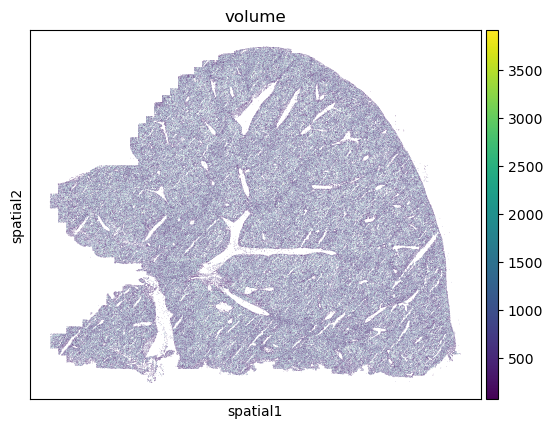

In [6]:
sc.pl.embedding(ad_sp, basis="spatial", color="volume")

In [7]:
ad_sp.var_names_make_unique()
ad_sp.var["mt"] = ad_sp.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    ad_sp, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True
)

In [8]:
sc.pp.filter_cells(ad_sp, min_counts=50)
sc.pp.filter_genes(ad_sp, min_cells=10)

In [9]:
print("normalize total")
sc.pp.normalize_total(ad_sp)
print("log transform")
sc.pp.log1p(ad_sp)
print("scale")
sc.pp.scale(ad_sp, max_value=10)

normalize total
log transform
scale


In [10]:
resolution = 1.5
print("PCA")
sc.tl.pca(ad_sp, svd_solver="arpack")
print("neighbors")
sc.pp.neighbors(ad_sp, n_neighbors=10, n_pcs=20)
print("UMAP")
sc.tl.umap(ad_sp)
print("Leiden")
sc.tl.leiden(ad_sp, resolution=resolution)

PCA
neighbors
UMAP
Leiden


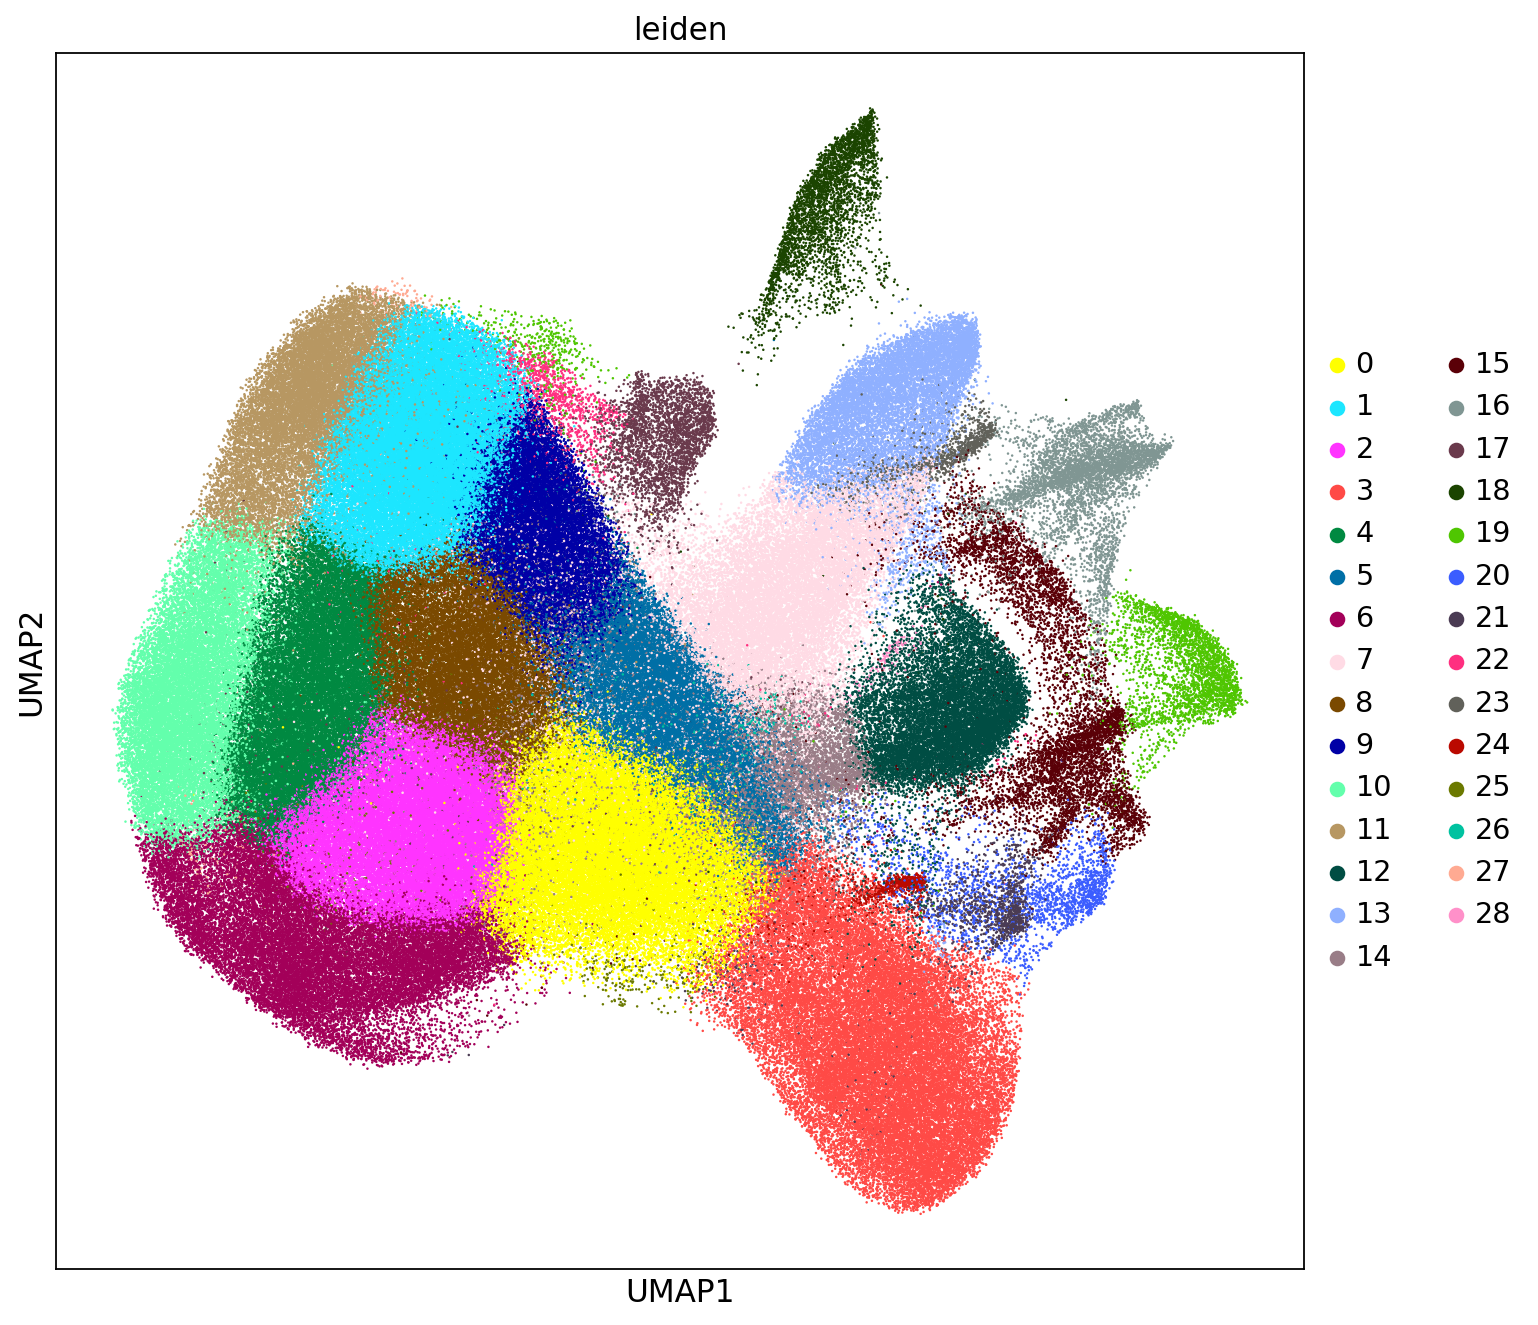

In [11]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(ad_sp, color=["leiden"], size=5)

In [17]:
ad_sp.write("vizgen.h5ad")

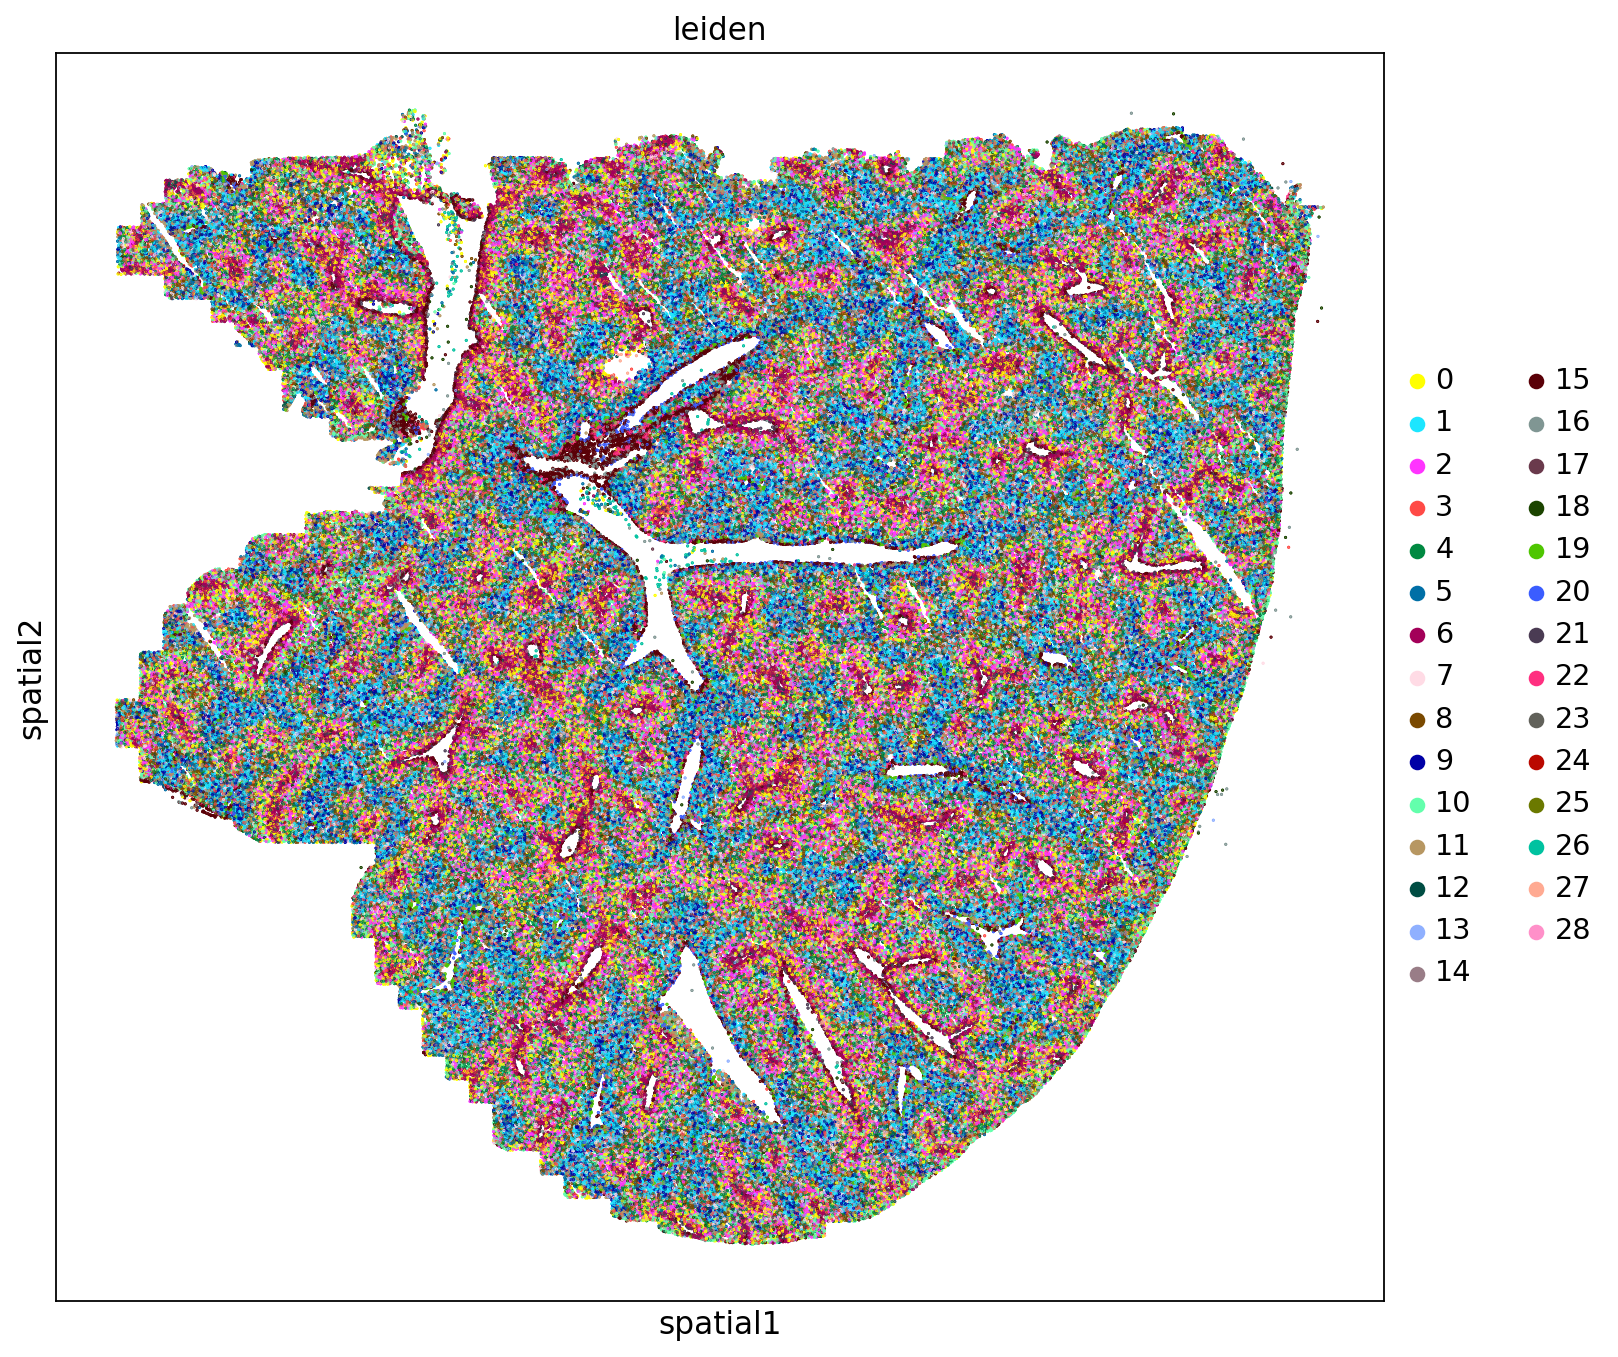

In [16]:
sq.pl.spatial_scatter(
    ad_sp, shape=None, color="leiden", size=0.5, library_id="spatial", figsize=(10, 10), save="spatial_umap.png"
)

In [19]:
sc.read_h5ad('vizgen.h5ad')

AnnData object with n_obs × n_vars = 367235 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'